In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

#from IPython.display import Image
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import skimage.transform
from scipy import ndimage

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.show()

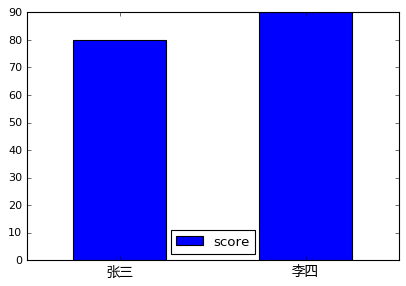

In [2]:
from pandas import DataFrame 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.font_manager import FontProperties 

font = FontProperties(fname="/home/gezi/soft/simsunttc/msyh.ttf", size=12)  #size可不用指定
#font = FontProperties(fname="/home/gezi/soft/simsunttc/simsun.ttc", size=12)  #size可不用指定

# linux 的中文字体 /usr/share/fonts/simhei/simhei.ttf

df = DataFrame({"score":[80, 90]}, index=["张三","李四"]) 
ax = df.plot(kind = 'bar', rot = 0) 
labels = [label.decode("utf-8") for label in df.index.values] 
ax.set_xticklabels(labels, fontproperties=font) 
plt.show()

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [4]:
import tensorflow as tf
import sys, os, math
import gezi, melt
import numpy as np

TEXT_MAX_WORDS = 100    
decode_max_words = 10

tensorflow_version: 1.2.0-rc0


In [5]:
import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

In [6]:
from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic/vocab.txt'
ids2text.init(vocab_path)

INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words


ENCODE_UNK 1


In [7]:
image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'
model_name='InceptionResnetV2'
image_model = melt.image.ImageModel(image_model_checkpoint_path, 
                                    model_name=model_name,
                                    feature_name=melt.image.get_features_name(model_name))

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt


restore image var from InceptionResnetV2 /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt duration: 2.98462104797


In [8]:
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell/'
predictor = melt.Predictor(model_dir)

INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model/showattentell/model.ckpt-25.6-105000


restore meta grpah and model ok /home/gezi/new/temp/image-caption/ai-challenger/model/showattentell/model.ckpt-25.6-105000 duration: 28.13646698


In [11]:
def predict(image_name, num_show=1):
  image_path = image_path = os.path.join(image_dir, image_name)
  feature = image_model.gen_feature(melt.read_image(image_path))
  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('feed')[0] : feature
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('feed')[0] : feature,
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=ids2text.end_id(), 
                                   max_words=decode_max_words, 
                                   length_normalization_factor=0.)


  for i, beam in enumerate(beams):
    if i == num_show:
      break

    print(i, beam.words, ids2text.ids2text(beam.words), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)

    # Plot images with attention weights
    words = beam.words    
    img = ndimage.imread(image_path)
    plt.clf()
    plt.subplot(4, 5, 1)
    plt.imshow(img)
    plt.axis('off')
    
    num_features = melt.image.get_num_features(model_name)
    dim = int(math.sqrt(num_features))
    
    for t in range(len(words)):
      plt.subplot(4, 5, t + 2)
      plt.text(0, 1, '%s(%.2f)' % (pinyin.Convert(ids2text.vocab.key(words[t]).decode('utf8').encode('gbk')), math.exp(beam.logprobs[t])), color='black', backgroundcolor='white',fontsize=8)  
      plt.imshow(img)
      alp_curr = beam.alignments_list[t].reshape([dim, dim])
      alp_img = skimage.transform.pyramid_expand(alp_curr, upscale=16, sigma=20)
      plt.imshow(alp_img, alpha=0.85)
      plt.axis('off')
    plt.savefig(str(i) + 'test.pdf')

  print('beam search using time(ms):', timer.elapsed_ms())

In [ ]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:')
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'
  predict(image_name)

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:a02e4a220b9973233d77d90658b74d52c10c0bd0.jpg
0 [10, 20, 73, 1, 14, 2, 62, 5, 81, 9] 一个/穿着/运动服/的/男人/在/运动场/上/踢足球/</S> 0.0233810016887 -3.75583 -3.75583 [-0.60450196, -0.3111428, -1.3762783, -0.0057475776, -0.12090515, -0.014540776, -1.272158, -0.0049367677, -0.045234434, -0.00038580605]
beam search using time(ms): 1317.75212288


In [ ]:
n_words = alpha.shape[0] + 1
w = numpy.round(numpy.sqrt(n_words))
h = numpy.ceil(numpy.float32(n_words) / w)
        
plt.subplot(w, h, 1)
plt.imshow(img)
plt.axis('off')

smooth = True

for ii in xrange(alpha.shape[0]):
    plt.subplot(w, h, ii+2)
    lab = words[ii]
    if options['selector']:
        lab += '(%0.2f)'%sels[ii]
    plt.text(0, 1, lab, backgroundcolor='white', fontsize=13)
    plt.text(0, 1, lab, color='black', fontsize=13)
    plt.imshow(img)
    if smooth:
        alpha_img = skimage.transform.pyramid_expand(alpha[ii,0,:].reshape(14,14), upscale=16, sigma=20)
    else:
        alpha_img = skimage.transform.resize(alpha[ii,0,:].reshape(14,14), [img.shape[0], img.shape[1]])
    plt.imshow(alpha_img, alpha=0.8)
    plt.set_cmap(cm.Greys_r)
    plt.axis('off')
plt.show()